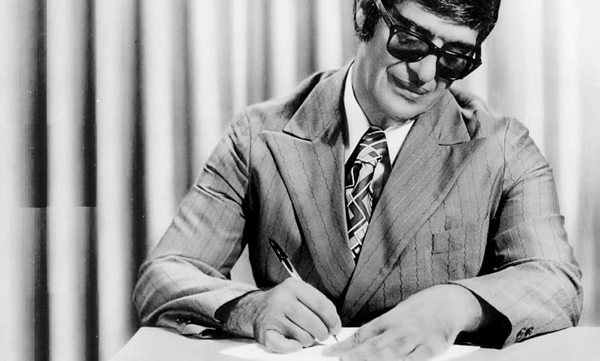

In [ ]:
#@title                                         Chico Xavier e a Similaridade de Cosseno
###A ideia do projeto é avaliar se atraves da similaridade de cosseno conseguimos identificar evidências que sugerem que os livros que Chico Xavier produziu em vida, de fato foram obras de diferentes espíritos.
from PIL import Image
from io import BytesIO
import requests

url = "https://img.migalhas.com.br/gf_base/empresas/MIGA/imagens/05F61AAF983031E217D22F0D4F3508F00E9D_chipb.jpg"
response = requests.get(url)
img = Image.open(BytesIO(response.content))

img.show()

A ideia do projeto é avaliar se através da similaridade de cosseno conseguimos identificar evidências que sugerem que os livros que Chico Xavier produziu em vida, poderiam ser obras de diferentes autores ou espíritos. Também optamos por trabalhar com modelos não supervisionados, como clusterização, para não cedermos nenhum tipo de viés ao modelo ao tentar identificar os padrões.

Import das biliotecas

In [ ]:
!pip install PyPDF2
!pip install pymupdf
!pip install -U spacy
!pip install pyspellchecker
import os
import re
import matplotlib.pyplot as plt
import nltk
import unicodedata
import spacy
import seaborn as sns
import pandas as pd
import requests
import gdown
import PyPDF2
import numpy as np
import fitz 
from statistics import median, mean, stdev
from nltk.tokenize import word_tokenize
from nltk.stem.snowball import SnowballStemmer
from nltk.corpus import machado, mac_morpho, stopwords
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from io import BytesIO
from google.colab import auth
from googleapiclient.discovery import build
from googleapiclient.errors import HttpError
from googleapiclient import errors
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from collections import Counter
from nltk.stem import RSLPStemmer
from collections import defaultdict
from spellchecker import SpellChecker
from googleapiclient.errors import HttpError
from googleapiclient.discovery import build
nltk.download('machado')
nltk.download('mac_morpho')
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('rslp')
auth.authenticate_user()
stemmer = RSLPStemmer()
spell = SpellChecker(language='pt')

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


[nltk_data] Downloading package machado to /root/nltk_data...
[nltk_data]   Package machado is already up-to-date!
[nltk_data] Downloading package mac_morpho to /root/nltk_data...
[nltk_data]   Package mac_morpho is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package rslp to /root/nltk_data...
[nltk_data]   Package rslp is already up-to-date!


Inicialmente vamos importar um depara que contém os autores (espíritos) de cada livro do Chico Xavier

In [ ]:
#informações do arquivo
id = '1iI1Xdu8EMDfD4_uqXO7J-elGDJMSU9JW'
url = f'https://drive.google.com/uc?id={id}'

#fazendo a requisição
response = requests.get(url)
content = response.content

#gerando df a partir do arquivo capturado
df = pd.read_excel(BytesIO(content), engine='openpyxl', sheet_name='Sheet1') 

#removendo duplicidade de títulos
df = df.drop_duplicates(subset=['NOME_ARQUIVO'])
df.head()

,Nº,TÍTULO,AUTOR,ANO,NOME_ARQUIVO
0,8.0,A CAMINHO DA LUZ,EMMANUEL,1939.0,acaminhodaluz
1,331.0,A SEMENTE DE MOSTARDA,EMMANUEL,1990.0,asementedemostarda
2,137.0,A TERRA E O SEMEADOR,EMMANUEL,1975.0,aterraeosemeador
3,341.0,A VERDADE RESPONDE,EMMANUEL / ANDRÉ LUIZ,1990.0,averdaderesponde
4,183.0,A VIDA CONTA,MARIA DOLORES,1980.0,avidaconta


In [ ]:
#verificando a quantidade de livros por autor presente no depara
df['AUTOR'].value_counts()

ESPÍRITOS DIVERSOS          174
EMMANUEL                    115
ANDRÉ LUIZ                   19
CORNÉLIO PIRES               16
IRMÃO X                       9
MARIA DOLORES                 7
MEIMEI                        7
CASIMIRO CUNHA                6
JAIR PRESENTE                 6
HUMBERTO DE CAMPOS            5
EMMANUEL / ANDRÉ LUIZ         5
AUGUSTO CEZAR NETTO           4
NEIO LÚCIO                    3
LAURINHO                      3
CARLOS AUGUSTO                3
HILÁRIO SILVA                 2
BEZERRA DE MENEZES            2
FRANCISCA CLOTILDE            2
VENERANDA                     2
BATUÍRA                       1
RICARDO TADEU                 1
FRANCISCO V. P. LORENZ        1
ESPIRITOS DIVERSOS            1
MARIA DOLORES / MEIMEI        1
IRMÃ CANDOCA                  1
JAIR PRSENTE                  1
ROBERTO MUSZKAT               1
TIAMINHO                      1
MAURÍCIO G. HENRIQUE          1
LINEU DE PAULA LEÃO JR.       1
MANUEL M. B BOCAGE            1
EMMANUEL

Import dos livros do Chico Xavier para realizar a análise.

In [ ]:
#função para listar os arquivos na pasta do google drive
def listar_arquivos_na_pasta(pasta_id):
    try:
        servico = build('drive', 'v3', cache_discovery=False)
        consulta = f"'{pasta_id}' in parents"
        token_pagina = None
        arquivos = []

        while True:
            resposta = servico.files().list(q=consulta, fields="nextPageToken, files(id, name, mimeType)",pageToken=token_pagina).execute()
            arquivos.extend(resposta.get('files', []))
            token_pagina = resposta.get('nextPageToken', None)

            if token_pagina is None:
                break

        return arquivos
    except HttpError as error:
        print(f'Ocorreu um erro: {error}')
        return None

In [ ]:
def capturar_livros(pasta, autores_considerar, maximo_livros,conteudos,livros_nome,autores_nome):

  #listar arquivos na pasta
  arquivos_pdf = listar_arquivos_na_pasta(pasta)

  #import dos conteudos
  for arquivo in arquivos_pdf:
    if arquivo['name'] != 'depara.xlsx':

      id = arquivo['id']
      servico = build('drive', 'v3', cache_discovery=False)
      request = servico.files().get_media(fileId=id)
      arquivo_binario = BytesIO(request.execute())

      livro = arquivo['name'].replace(".pdf", "")
      
      if len(autores_considerar) >1:
        autor = df[df['NOME_ARQUIVO'] == livro]['AUTOR'].to_list()[0]
      else:
        autor = autores_considerar[0]
      if len(autor) >= 1 and autor in autores_considerar and len(list(filter(lambda x: x == autor, autores_nome))) <= maximo_livros:
          try:
              #abrir o documento PDF
              arquivo_binario.seek(0)
              doc = fitz.open(stream=arquivo_binario, filetype='pdf')
              conteudo = ''

              #iterar pelas páginas e extrair o texto
              for pagina in doc:
                  conteudo += pagina.get_text("text")

              #limpar o texto
              conteudo = conteudo.replace('.', ' ')
              conteudo = conteudo.replace(',', ' ')
              conteudo = conteudo.replace(' \n', ' ')
              conteudo = conteudo.replace('\n ', ' ')
              conteudo = conteudo.replace('\n', '')
              conteudo = conteudo.replace('  ', ' ')
              conteudo = conteudo.replace('   ', ' ')
              conteudo = re.sub(r'\d+', '', conteudo)
              conteudo = re.sub(r'[^\w\s.!?\-,]', '', conteudo)
              conteudo = unicodedata.normalize('NFKD', conteudo).encode('ASCII', 'ignore').decode('ASCII')

              #colocar tudo em minúsculo
              conteudo = conteudo.lower()

              #considerar apenas conteudo com mais de 50.000 palavras
              if len(conteudo) >= 50000:
                  livros_nome.append(livro)
                  autores_nome.append(autor)
                  conteudos.append(conteudo)

          except:
              pass
  return livros_nome, autores_nome, conteudos 
livros_nome, autores_nome, conteudos = capturar_livros('1t_cOHuuayBJV6XJszExFE8A-OorzU-He',['EMMANUEL', 'ANDRÉ LUIZ'],1000,[],[],[])

Criação de stopwords adicionando o nome dos autores como termos a serem retirados do texto

In [ ]:
def cria_stopwords():
  unique_authors = set()
  for autor in df['AUTOR'].unique():
      autor_lower = autor.lower()
      
      #Adiciona o nome completo
      unique_authors.add(autor_lower)

      #Adiciona o primeiro nome e todos os sobrenomes, se houver
      name_parts = autor_lower.split()
      if len(name_parts) > 1:
          unique_authors.add(name_parts[0])
          for surname in name_parts[1:]:
              unique_authors.add(surname)

  # Converte o conjunto em uma lista
  unique_authors_list = list(unique_authors)

  # Baixar a lista de stopwords para português e remover palavras adicionais
  stop_words = stopwords.words('portuguese')
  stop_words = stop_words.append(unique_authors_list) 
  return stop_words
stop_words = cria_stopwords()

Criar um vetorizador TF-IDF para todos os livros

In [ ]:
def criar_matriz():

  vectorizer = TfidfVectorizer(input='content', stop_words=stop_words, max_df=0.7, min_df=0.1, ngram_range=(1, 4))
  matriz_tfidf = vectorizer.fit_transform(conteudos)

  return matriz_tfidf
matriz_tfidf = criar_matriz()

Calcula a similaridade de cosseno, gera os clusters, utiliza PCA para reduzir a dimensionalidade e plotar o gráfico

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


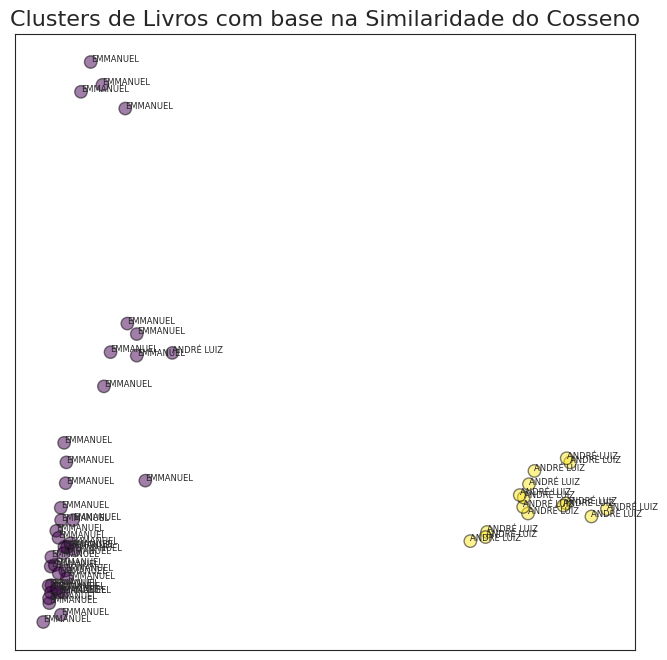

In [ ]:
def gera_grafico(substrai_clusters,exibe_rotulos):
    #calculo da similaridade do cosseno entre todos os livros
    similaridade_cosseno = cosine_similarity(matriz_tfidf)

    #escolhendo o número de clusters de acordo com a quantidade de autores, sendo a variável "subtrai clusters" utilizada quando desejamos atribuir 
    #mais de um autor ao mesmo cluster
    num_clusters = len(set(autores_nome)) - substrai_clusters

    #criar o modelo de cluster KMeans
    kmeans = KMeans(n_clusters=num_clusters, random_state=42)
    kmeans.fit(similaridade_cosseno)

    #redução da dimensionalidade dos dados com PCA para facilitar a visualização gráfica
    reduced_data = PCA(n_components=2).fit_transform(similaridade_cosseno)

    #estilo do gráfico usando seaborn
    sns.set_style("white")
    sns.set_palette("husl")

    #plot dos clusters em um gráfico de dispersão e adicionando o nome do autor em cada rótulo
    plt.figure(figsize=(8,8))
    plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=kmeans.labels_, cmap='viridis', s=80, alpha=0.5, edgecolors="black")

    # Alterar o valor de fonte
    fontsize = 6

    if exibe_rotulos == 1:
      for i, autor in enumerate(autores_nome):
          plt.annotate(autor, (reduced_data[i, 0], reduced_data[i, 1]), fontsize=fontsize) #fontweight="bold")

    plt.title('Clusters de Livros com base na Similaridade do Cosseno', fontsize=16)
    plt.gca().set_xticklabels([])
    plt.gca().set_yticklabels([])
    plt.gca().spines[['top', 'right', 'left', 'bottom']].set_visible(True)
    plt.show()

    return kmeans.labels_, autores_nome, num_clusters, livros_nome

cluster_labels, autores_nome, num_clusters, nomes_livros = gera_grafico(0,1);


Neste primeiro teste apenas um livro do André Luiz ficou classificado no mesmo cluster dos livros de Emmanuel, todos os demais livros o modelo conseguiu separar de acordo com o espírito autor através da frequência de palavras nos textos e da importância que elas possuem no estilo literário do autor.

In [ ]:
#Criação do dataframe para verificar os resultados
def create_dataframe(cluster_labels, autores_nome, nomes_livros):
    data = {'Autor': autores_nome, 'Livro': nomes_livros, 'Cluster': cluster_labels}
    df = pd.DataFrame(data)
    return df

In [ ]:
df_cluster = create_dataframe(cluster_labels, autores_nome, nomes_livros)
df_cluster.head()

,Autor,Livro,Cluster
0,ANDRÉ LUIZ,eavidacontinua,1
1,ANDRÉ LUIZ,osmensageiros,0
2,ANDRÉ LUIZ,nossolar,1
3,EMMANUEL,luznocaminho,0
4,EMMANUEL,novomundo,0


In [ ]:
#agrupar por autor e Cluster e contar o número de livros em cada grupo
def resumir_dados(df_cluster):
    resumo = df_cluster.groupby(['Autor', 'Cluster']).count().reset_index()
    resumo.rename(columns={'Livro': 'Quantidade'}, inplace=True)
    resumo['Cluster'] = resumo['Cluster'].replace({0: 1, 1: 2, 2:3, 3:4})
    return resumo
df_resumido = resumir_dados(df_cluster)
df_resumido 

,Autor,Cluster,Quantidade
0,ANDRÉ LUIZ,1,1
1,ANDRÉ LUIZ,2,15
2,EMMANUEL,1,39


Segundo teste com Emmanuel, André Luiz e Humberto de Campos. Neste segundo teste reduzimos a quantidade máxima de livros por autor porque Humberto de Campos não possui tantos livros escritos por Chico, como os demais autores. E possui apenas 3 livros com mais de 50.000 palavras (corte que estamos utilizando para termos dados suficientes para analisar). Então para termos amostras equilibradas de cada autor iremos trabalhar com um limite máximo de livros.

In [ ]:
#capturando livros
livros_nome, autores_nome, conteudos = capturar_livros('1t_cOHuuayBJV6XJszExFE8A-OorzU-He',['EMMANUEL', 'ANDRÉ LUIZ', 'HUMBERTO DE CAMPOS'],4,[],[],[])

In [ ]:
#criando a matriz
matriz_tfidf = criar_matriz()

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


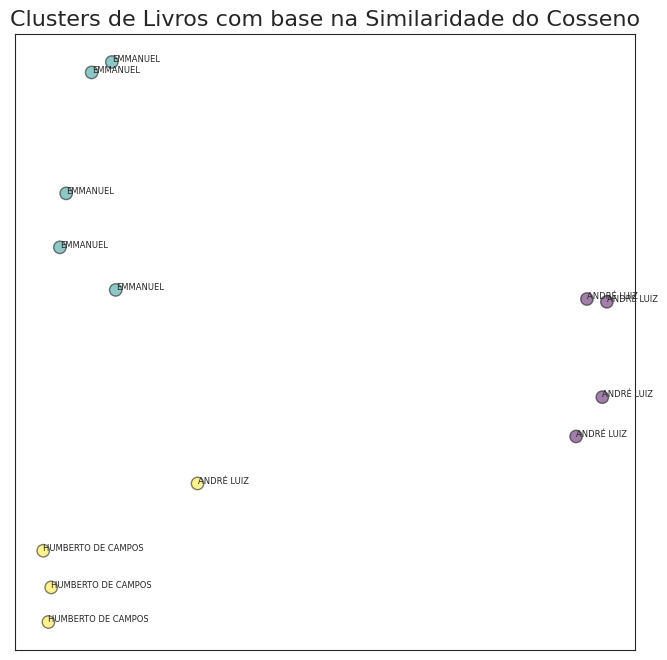

In [ ]:
#similaridade de cosseno, clusterização, pca e gráfico
cluster_labels, autores_nome, num_clusters, nomes_livros = gera_grafico(substrai_clusters=0,exibe_rotulos=1);

Neste segundo teste, novamente apenas um livro de André Luiz ficou classificado junto com livros de Humberto de Campos, todos os demais livros foram separados "corretamente" no cluster de cada espírito.

In [ ]:
#criação do df com os resultados
df_cluster = create_dataframe(cluster_labels, autores_nome, nomes_livros)

In [ ]:
#Gera resumo
df_resumido = resumir_dados(df_cluster)
df_resumido 

,Autor,Cluster,Quantidade
0,ANDRÉ LUIZ,1,4
1,ANDRÉ LUIZ,3,1
2,EMMANUEL,2,5
3,HUMBERTO DE CAMPOS,3,3


Terceiro teste: iremos acrescentar livros que Humberto de Campos escreveu em vida ao mesmo público de livros que trabalhamos no teste anterior. A ideia é verificar se o modelo irá agrupar estes livros escritos em vida por Humberto no mesmo cluster dos livros que ele teria ditado para Chico, segundo o espiritismo.

In [ ]:
#capturando livros
livros_nome, autores_nome, conteudos = capturar_livros('1atGXLrGe9JC4mPnorebVRA6s-7_hzchC',['HUMBERTO CAMPOS (EM VIDA)'],4,conteudos,livros_nome,autores_nome)

In [ ]:
#criando a matriz
matriz_tfidf = criar_matriz()

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


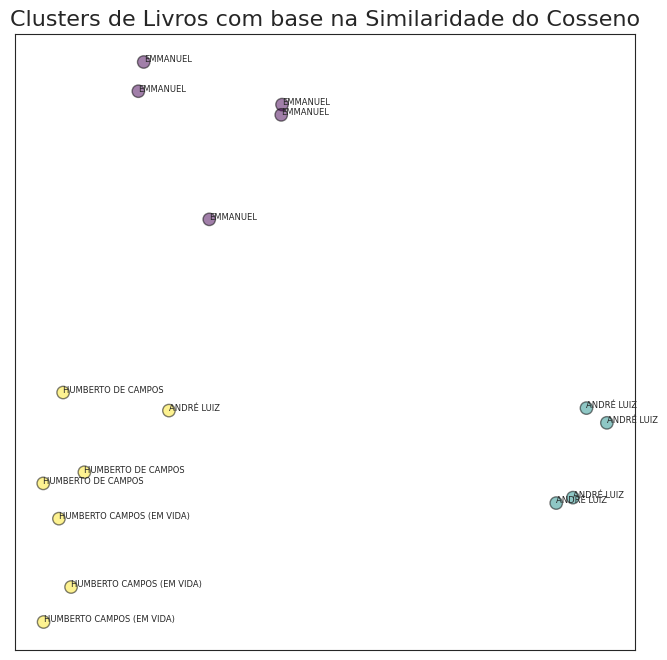

In [ ]:
#similaridade de cosseno, clusterização, pca e gráfico
cluster_labels, autores_nome, num_clusters, nomes_livros = gera_grafico(substrai_clusters=1,exibe_rotulos=1);

Novamente, um livro de André Luiz ficou classificado no cluster de outro autor. Contudo, neste teste notamos que o modelo conseguiu identificar semelhanças entre os livros que Humberto de Campos escreveu em vida com os que, segundo o espiritismo, ditou para Chico Xavier.

In [ ]:
#criação do df com os resultados
df_cluster = create_dataframe(cluster_labels, autores_nome, nomes_livros)

In [ ]:
#Gera resumo
df_resumido = resumir_dados(df_cluster)
df_resumido 

,Autor,Cluster,Quantidade
0,ANDRÉ LUIZ,2,4
1,ANDRÉ LUIZ,3,1
2,EMMANUEL,1,5
3,HUMBERTO CAMPOS (EM VIDA),3,3
4,HUMBERTO DE CAMPOS,3,3


O estudo apresentado permite deduzir que existem padrões consistentes nas obras de Chico Xavier, padrões estes que possibilitam categorizar os livros de acordo com o suposto espírito que, de acordo com a doutrina espírita, teria orientado a criação da obra por meio de Chico Xavier. Esses padrões emergem até mesmo em modelos não supervisionados.

Contudo, é importante ressaltar que o estudo não pretende, nem acredita ser possível, afirmar definitivamente se foram ou não espíritos que inspiraram as obras. No entanto, as análises propiciam reflexões intrigantes. 

Se existem padrões distintos nos livros, poderia Chico Xavier ter a capacidade de ouvir coisas que nós, meros mortais, não conseguimos? Ou, em contrapartida, poderia Chico Xavier ter sido hábil o suficiente para simular variados estilos literários, a ponto de replicar de maneira quase perfeita o estilo de um escritor já falecido? Mas qual seria o propósito disso, considerando que ele nunca obteve qualquer benefício material em troca?

A partir deste ponto, a ciência reconhece suas limitações, e a fé de cada indivíduo passa a direcionar as respostas.